In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# required machine learning packages
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
df = pd.read_csv("spreadspoke_scores.csv")
teams = pd.read_csv("nfl_teams.csv")
teams_clean = pd.read_csv("nfl_teams_clean.csv")
games_elo = pd.read_csv("nfl_elo.csv")

In [3]:
# replacing blank strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# removing rows from specific columns that have null values, resetting index and changing data types
df = df[(df.score_home.isnull() == False) & (df.team_favorite_id.isnull() == False) & (df.over_under_line.isnull() == False) &
        (df.schedule_season >= 1979)]

df.reset_index(drop=True, inplace=True)
df['over_under_line'] = df.over_under_line.astype(float)

# mapping team_id to the correct teams
df['team_home'] = df.team_home.map(teams.set_index('team_name')['team_id'].to_dict())
df['team_away'] = df.team_away.map(teams.set_index('team_name')['team_id'].to_dict())

# fix team_favorite_id for Colts in 1969 and 1971 SB
df.loc[(df.schedule_season == 1968) & (df.schedule_week == 'Superbowl'), 'team_favorite_id'] = 'IND'
df.loc[(df.schedule_season == 1970) & (df.schedule_week == 'Superbowl'), 'team_favorite_id'] = 'IND'

# creating home favorite and away favorite columns (fill na with 0's)
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.loc[df.team_favorite_id == df.team_away, 'away_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)
df.away_favorite.fillna(0, inplace=True)

# creating over / under column (fill na with 0's)
df.loc[((df.score_home + df.score_away) > df.over_under_line), 'over'] = 1
df.over.fillna(0, inplace=True)

# stadium neutral and schedule playoff as boolean
df['stadium_neutral'] = df.stadium_neutral.astype(int)
df['schedule_playoff'] = df.schedule_playoff.astype(int)

# change data type of date columns
df['schedule_date'] = pd.to_datetime(df['schedule_date'])
games_elo['date'] = pd.to_datetime(games_elo['date'])

In [4]:
# fixing some schedule_week column errors and converting column to integer data type
df.loc[(df.schedule_week == '18'), 'schedule_week'] = '17'
df.loc[(df.schedule_week == 'Wildcard') | (df.schedule_week == 'WildCard'), 'schedule_week'] = '18'
df.loc[(df.schedule_week == 'Division'), 'schedule_week'] = '19'
df.loc[(df.schedule_week == 'Conference'), 'schedule_week'] = '20'
df.loc[(df.schedule_week == 'Superbowl') | (df.schedule_week == 'SuperBowl'), 'schedule_week'] = '21'
df['schedule_week'] = df.schedule_week.astype(int)

In [5]:
# Cleaning games_elo and df to merge correctly
wsh_map = {'WSH' : 'WAS'}
games_elo.loc[games_elo.team1 == 'WSH', 'team1'] = 'WAS' 
games_elo.loc[games_elo.team2 == 'WSH', 'team2'] = 'WAS'

# fix dates
df.loc[(df.schedule_date == '2016-09-19') & (df.team_home == 'MIN'), 'schedule_date'] = datetime.datetime(2016, 9, 18)
df.loc[(df.schedule_date == '2017-01-22') & (df.schedule_week == 21), 'schedule_date'] = datetime.datetime(2017, 2, 5)
df.loc[(df.schedule_date == '1990-01-27') & (df.schedule_week == 21), 'schedule_date'] = datetime.datetime(1990, 1, 28)
df.loc[(df.schedule_date == '1990-01-13'), 'schedule_date'] = datetime.datetime(1990, 1, 14)
games_elo.loc[(games_elo.date == '2016-01-09'), 'date'] = datetime.datetime(2016, 1, 10)
games_elo.loc[(games_elo.date == '2016-01-08'), 'date'] = datetime.datetime(2016, 1, 9)
games_elo.loc[(games_elo.date == '2016-01-16'), 'date'] = datetime.datetime(2016, 1, 17)
games_elo.loc[(games_elo.date == '2016-01-15'), 'date'] = datetime.datetime(2016, 1, 16)

In [6]:
# Drop season before 2000
df = df.drop(df[df.schedule_season < 2000].index)

In [7]:
# Current Win-Loss% and Last season Win-Loss%
# A very hacky method could take a few minutes
for team in teams.team_id.unique().tolist():
    for season in range(2000,2019): 
        
        wins, games_played = 0., 0.
        
        for week in range(1,18):
            current_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == week)]
            
            # If a game exists
            if(current_game.shape[0] == 1):
                current_game = current_game.iloc[0]
                
    
                if ((current_game.team_home == team) & (current_game.score_home > current_game.score_away)):
                    wins += 1
                    
                elif ((current_game.team_away == team) & (current_game.score_away > current_game.score_home)):
                    wins += 1
                
                # If not a tie count game as part of record
                if(current_game.score_away != current_game.score_home):
                    games_played += 1
                
                # If week one put default record as 0
                if(week == 1):
                    if(current_game.team_home == team):
                        df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == week), 'team_home_current_win_pct'] = 0 
                    else:
                        df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == week), 'team_away_current_win_pct'] = 0 

            # Put record for next week game and account for bye week
            next_week_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == week+1)]
            # If a game exists
            if(next_week_game.shape[0] == 1):
                next_week_game = next_week_game.iloc[0]
                if(next_week_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == week+1), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                else:
                    df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == week+1), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played
            else: # Bye week
                next_twoweek_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == week+2)]
                # If a game exists
                if(next_twoweek_game.shape[0] == 1):
                    next_twoweek_game = next_twoweek_game.iloc[0]
                    if(next_twoweek_game.team_home == team):
                        df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == week+2), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                    else:
                        df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == week+2), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played

                    
        # if beyond week 17 (playoffs use season record)
        for postseason_week in range(18,22):
            current_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == postseason_week)]
            # If a game exists
            if(current_game.shape[0] == 1):
                current_game = current_game.iloc[0]
                if(current_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == postseason_week), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                else:
                    df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == postseason_week), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played
           
        # if week 17 put current in next season
        # if last season is 2000 (no record) put in as 
        next_season = season+1
        for week in range(1,22):
            next_season_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == next_season) & (df.schedule_week == week)]
            if(next_season_game.shape[0] == 1):
                next_season_game = next_season_game.iloc[0]
                if(next_season_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == next_season) & (df.schedule_week == week), 'team_home_lastseason_win_pct'] = 0 if games_played == 0 else wins/games_played
                elif(next_season_game.team_away == team):
                    df.loc[(df.team_away == team) & (df.schedule_season == next_season) & (df.schedule_week == week), 'team_away_lastseason_win_pct'] = 0 if games_played == 0 else wins/games_played

In [8]:
# Drop season before 2001
df = df.drop(df[df.schedule_season < 2001].index)

In [9]:
# Get division info. in each team to create 'division_game' flag
df = pd.merge(df, teams_clean[["team_id", "team_division"]], how='inner', left_on=['team_home'], right_on=['team_id'])
df = pd.merge(df, teams_clean[["team_id", "team_division"]], how='inner', left_on=['team_away'], right_on=['team_id'])
df = df.rename(columns={'team_division_x': 'team_home_division', 'team_division_y': 'team_away_division'})

# # drop unused columns
df = df.drop(['team_id_x', 'team_id_y'], axis=1)

df["division_game"] = df["team_home_division"] == df["team_away_division"]

In [10]:
df = df.merge(games_elo[['date', 'team1', 'team2', 'elo_prob1', 'elo_prob2']], 
                      left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')

# merge to fix neutral games where team_home and team_away are switched
games_elo2 = games_elo.rename(columns={'team1' : 'team2', 
                                       'team2' : 'team1', 
                                       'elo1' : 'elo2', 
                                       'elo2' : 'elo1',
                                       'elo_prob1' : 'elo_prob2', 
                                       'elo_prob2' : 'elo_prob1'})

df = df.merge(games_elo2[['date', 'team1', 'team2', 'elo_prob1', 'elo_prob2']], 
                      left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')


In [11]:
# separating merged columns into x and y cols
x_cols = ['date_x', 'team1_x', 'team2_x', 'elo_prob1_x', 'elo_prob2_x']
y_cols = ['date_y', 'team1_y', 'team2_y', 'elo_prob1_y','elo_prob2_y']

# filling null values for games_elo merged cols
for x, y in zip(x_cols, y_cols):
    df[x] = df[x].fillna(df[y]) 
    
df = df[['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
        'elo_prob1_x', 'elo_prob2_x']]

# remove _x ending from column names
df.columns = df.columns.str.replace('_x', '')

In [12]:
# Drop column where there are eno Elo information
df = df.dropna(subset=['elo_prob1', 'elo_prob2'])

In [13]:
# creating result column df.loc[(df.score_home > df.score_away), 'result'
df['result'] = (df.score_home > df.score_away).astype(int)

In [14]:
# creating home favorite and away favorite columns (fill na with 0's)
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.loc[df.team_favorite_id == df.team_away, 'away_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)
df.away_favorite.fillna(0, inplace=True)

In [15]:
# Change boolean column to 0/1
df.division_game = df.division_game.astype(int)
df.home_favorite = df.home_favorite.astype(int)
df.away_favorite = df.away_favorite.astype(int)

In [16]:
df.to_csv("data_preprocessed.csv", index=False)

In [17]:
# Read preprocessed csv file so don't have to run data preprocessing again
df = pd.read_csv("data_preprocessed.csv")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4783 entries, 0 to 4782
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   schedule_date                 4783 non-null   object 
 1   schedule_season               4783 non-null   int64  
 2   schedule_week                 4783 non-null   int64  
 3   schedule_playoff              4783 non-null   int64  
 4   team_home                     4783 non-null   object 
 5   score_home                    4783 non-null   float64
 6   score_away                    4783 non-null   float64
 7   team_away                     4783 non-null   object 
 8   team_favorite_id              4783 non-null   object 
 9   spread_favorite               4783 non-null   float64
 10  over_under_line               4783 non-null   float64
 11  stadium                       4783 non-null   object 
 12  stadium_neutral               4783 non-null   int64  
 13  wea

In [19]:
df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
       'elo_prob1', 'elo_prob2', 'result'], dtype=object)

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
schedule_season,4783.0,2009.490069,5.171005,2001.000000,2005.000000,2009.000000,2014.000000,2018.000000
schedule_week,4783.0,9.486933,5.254918,1.000000,5.000000,10.000000,14.000000,21.000000
schedule_playoff,4783.0,0.038261,0.191845,0.000000,0.000000,0.000000,0.000000,1.000000
score_home,4783.0,23.237090,10.367254,0.000000,16.000000,23.000000,30.000000,62.000000
score_away,4783.0,20.686180,10.045255,0.000000,13.000000,20.000000,27.000000,59.000000
spread_favorite,4783.0,-5.374242,3.387991,-26.500000,-7.000000,-4.500000,-3.000000,0.000000
over_under_line,4783.0,43.237194,4.908705,30.000000,40.000000,43.500000,46.500000,63.500000
stadium_neutral,4783.0,0.011499,0.106626,0.000000,0.000000,0.000000,0.000000,1.000000
weather_temperature,4672.0,60.571918,15.593036,-6.000000,50.000000,65.000000,72.000000,97.000000
weather_wind_mph,4672.0,6.284889,5.440553,0.000000,0.000000,6.000000,10.000000,40.000000


In [21]:
# null values by column
df.isnull().sum(axis=0)

schedule_date                      0
schedule_season                    0
schedule_week                      0
schedule_playoff                   0
team_home                          0
score_home                         0
score_away                         0
team_away                          0
team_favorite_id                   0
spread_favorite                    0
over_under_line                    0
stadium                            0
stadium_neutral                    0
weather_temperature              111
weather_wind_mph                 111
weather_humidity                2352
weather_detail                  3441
home_favorite                      0
away_favorite                      0
over                               0
team_away_current_win_pct          0
team_home_current_win_pct          0
team_home_lastseason_win_pct       0
team_away_lastseason_win_pct       0
team_home_division                 0
team_away_division                 0
division_game                      0
e

In [22]:
# some percentages to take into consideration when betting
# home_win = "{:.2f}".format((sum((df.result == 1) & (df.stadium_neutral == 0)) / len(df)) * 100)
home_win = "{:.2f}".format((sum((df.result == 1) & (df.stadium_neutral == 0)) / sum(df.stadium_neutral == 0)) * 100)
# away_win = "{:.2f}".format((sum((df.result == 0) & (df.stadium_neutral == 0)) / len(df)) * 100)
away_win = "{:.2f}".format((sum((df.result == 0) & (df.stadium_neutral == 0)) / sum(df.stadium_neutral == 0)) * 100)

under_line = "{:.2f}".format((sum((df.score_home + df.score_away) < df.over_under_line) / len(df)) * 100)
over_line = "{:.2f}".format((sum((df.score_home + df.score_away) > df.over_under_line) / len(df)) * 100)
equal_line = "{:.2f}".format((sum((df.score_home + df.score_away) == df.over_under_line) / len(df)) * 100)

favored = "{:.2f}".format((sum(((df.home_favorite == 1) & (df.result == 1)) | ((df.away_favorite == 1) & (df.result == 0)))
                           / len(df)) * 100)


cover = "{:.2f}".format((sum(((df.home_favorite == 1) & ((df.score_away - df.score_home) < df.spread_favorite)) | 
                             ((df.away_favorite == 1) & ((df.score_home - df.score_away) < df.spread_favorite))) # use score_home - score_away because the fav are swap
                         / len(df)) * 100)

ats = "{:.2f}".format((sum(((df.home_favorite == 1) & ((df.score_away - df.score_home) > df.spread_favorite)) | 
                           ((df.away_favorite == 1) & ((df.score_home - df.score_away) > df.spread_favorite))) 
                       / len(df)) * 100)

In [23]:
# print all percentages
print("Number of Games: " + str(len(df)))
print("Home Straight Up Win Percentage: " + home_win + "%")
print("Away Straight Up Win Percentage: " + away_win + "%")
print("Under Percentage: " + under_line + "%")
print("Over Percentage: " + over_line + "%")
print("Equal Percentage: " + equal_line + "%")
print("Favored Win Percentage: " + favored + "%")
print("Cover The Spread Percentage: " + cover + "%")
print("Against The Spread Percentage: " + ats + "%")

Number of Games: 4783
Home Straight Up Win Percentage: 57.57%
Away Straight Up Win Percentage: 42.43%
Under Percentage: 49.70%
Over Percentage: 48.55%
Equal Percentage: 1.76%
Favored Win Percentage: 65.96%
Cover The Spread Percentage: 46.96%
Against The Spread Percentage: 49.32%


In [24]:
pd.set_option('display.max_columns', 500)
df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,home_favorite,away_favorite,over,team_away_current_win_pct,team_home_current_win_pct,team_home_lastseason_win_pct,team_away_lastseason_win_pct,team_home_division,team_away_division,division_game,elo_prob1,elo_prob2,result
0,2001-09-09,2001,1,0,BAL,17.0,6.0,CHI,BAL,-10.5,33.5,M&T Bank Stadium,0,72.0,6.0,79.0,NaN,1,0,0.0,0.000000,0.000000,0.7500,0.3125,AFC North,NFC North,0,0.847023,0.152977,1
1,2009-12-20,2009,15,0,BAL,31.0,7.0,CHI,BAL,-11.0,39.0,M&T Bank Stadium,0,30.0,12.0,68.0,NaN,1,0,0.0,0.384615,0.538462,0.6875,0.5625,AFC North,NFC North,0,0.781479,0.218521,1
2,2017-10-15,2017,6,0,BAL,24.0,27.0,CHI,BAL,-6.5,38.5,M&T Bank Stadium,0,73.0,10.0,NaN,NaN,1,0,1.0,0.200000,0.600000,0.5000,0.1875,AFC North,NFC North,0,0.751455,0.248545,0
3,2002-09-29,2002,4,0,BUF,33.0,27.0,CHI,BUF,-3.0,46.5,Ralph Wilson Stadium,0,57.0,9.0,76.0,NaN,1,0,1.0,0.666667,0.333333,0.1875,0.8125,AFC East,NFC North,0,0.401823,0.598177,1
4,2010-11-07,2010,9,0,BUF,19.0,22.0,CHI,CHI,-3.0,41.5,Rogers Centre,1,72.0,0.0,NaN,DOME,0,1,0.0,0.571429,0.000000,0.3750,0.4375,AFC East,NFC North,0,0.421488,0.578512,0


<AxesSubplot:xlabel='result', ylabel='count'>

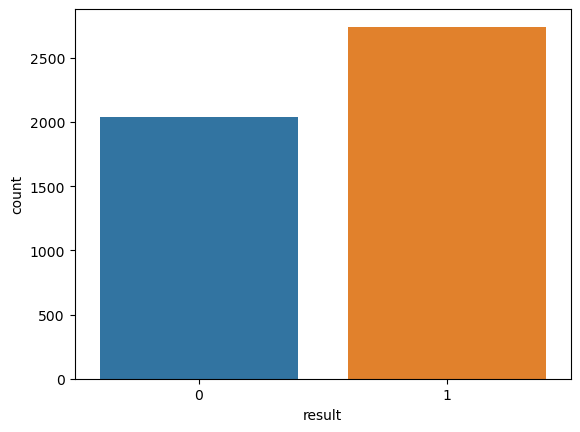

In [25]:
sns.countplot(x="result", data=df)

In [26]:
df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
       'elo_prob1', 'elo_prob2', 'result'], dtype=object)

In [27]:
# training and testing data
train = df.copy()
test = df.copy()
train = train.loc[train['schedule_season'] < 2016]
test = test.loc[test['schedule_season'] > 2015]

X_train = train[['schedule_week', 'spread_favorite', 'over_under_line', 'home_favorite','team_away_current_win_pct', 'team_home_current_win_pct', 
                 'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct', 'division_game', 'elo_prob1']]
y_train = train['result']

X_test = test[['schedule_week', 'spread_favorite', 'over_under_line', 'home_favorite','team_away_current_win_pct', 'team_home_current_win_pct', 
               'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct', 'division_game', 'elo_prob1']]
y_test = test['result']

In [28]:
##############First edits############
#############Run PCA to determine which features are most important##############
from sklearn.decomposition import PCA
n_components = 10  #Start with all components

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)
print("Cumulative Explained Variance:", explained_variance.cumsum())



Explained Variance Ratios: [4.39096616e-01 3.72521655e-01 1.77690115e-01 3.91954902e-03
 3.55069898e-03 1.39495979e-03 7.13959100e-04 5.51664047e-04
 4.92999844e-04 6.77835406e-05]
Cumulative Explained Variance: [0.43909662 0.81161827 0.98930839 0.99322793 0.99677863 0.99817359
 0.99888755 0.99943922 0.99993222 1.        ]


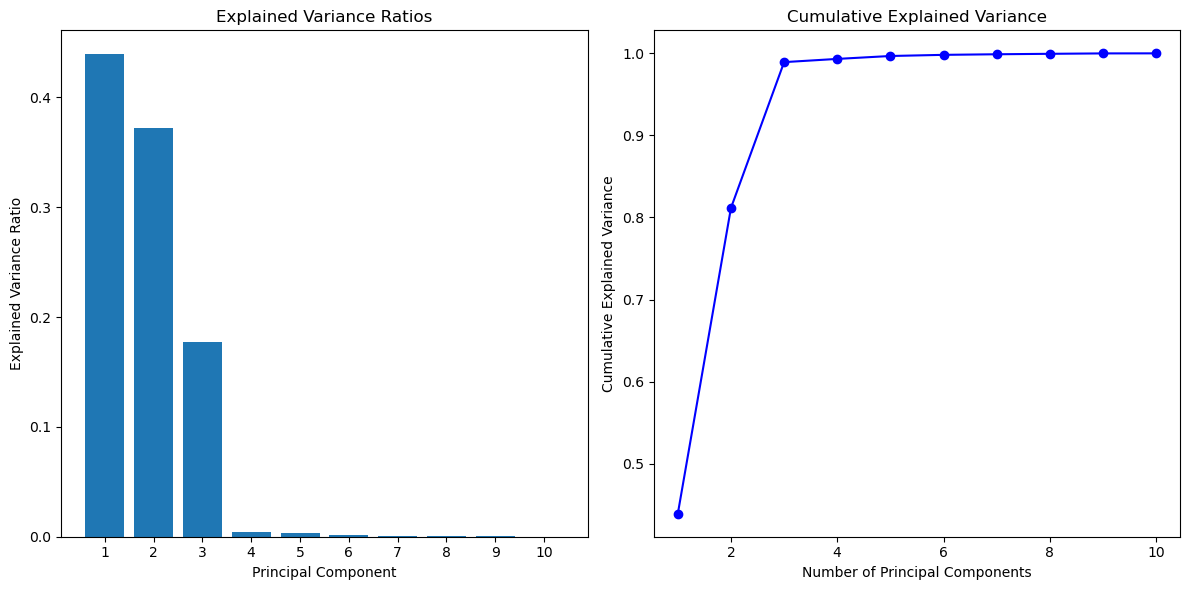

In [29]:
import matplotlib.pyplot as plt

# Create a bar plot for explained variance ratios
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, tick_label=range(1, len(explained_variance) + 1))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratios')

# Create a line plot for cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(explained_variance.cumsum()) + 1), explained_variance.cumsum(), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')

plt.tight_layout()
plt.show()

In [30]:
##### Most of our variance is predicted in the first few principles we will keep 5
#### We will only wory about this data and not overload our model
X_train = train[['schedule_week', 'spread_favorite', 'over_under_line', 'home_favorite','team_away_current_win_pct']]
y_train = train['result']

X_test = test[['schedule_week', 'spread_favorite', 'over_under_line', 'home_favorite','team_away_current_win_pct']]
y_test = test['result']

In [31]:
# prepare models
models = []

# Classifiers to use in Voting
boost = xgb.XGBClassifier()
dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
lrg = LogisticRegression(solver='liblinear')
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')

models.append(('LRG', LogisticRegression(solver='liblinear', max_iter=250)))
models.append(('KNB', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('XGB', xgb.XGBClassifier(random_state=0)))
models.append(('RFC', RandomForestClassifier(random_state=0, n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=5)))
models.append(('SVC', LinearSVC(random_state=0)))
models.append(('VOTE', VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')))
models.append(('CCV', CCV(vote, method='isotonic', cv=3)))
models.append(('MLP', MLPClassifier()))
models.append(('ADA', AdaBoostClassifier(random_state=0)))

# evaluate each model by average of roc auc 
results_dict = {}

for name, m in models:
    kfold = model_selection.KFold(n_splits=5) 
    cv_results = model_selection.cross_val_score(m, X_train, y_train, cv=kfold, scoring = 'roc_auc') # or 'accuracy'
    results_dict.update({name: "%f" % cv_results.mean()})

C:\Users\samsn\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\samsn\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\samsn\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\samsn\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\samsn\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [32]:
# results_dict
sorted(((v,k) for k,v in results_dict.items()), reverse=True)

[('0.690826', 'MLP'),
 ('0.690575', 'DTC'),
 ('0.685436', 'CCV'),
 ('0.682190', 'LRG'),
 ('0.681179', 'VOTE'),
 ('0.674037', 'GNB'),
 ('0.670978', 'ADA'),
 ('0.666330', 'SVC'),
 ('0.648604', 'RFC'),
 ('0.632094', 'XGB'),
 ('0.581224', 'KNB')]

In [33]:
# Fit best model to all of training set
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')
model = vote.fit(X_train, y_train)

In [34]:
# predict probabilities
predicted = model.predict_proba(X_test)[:,1]

In [35]:
# predict home team win or lose (0/1)
predictions = model.predict(X_test)

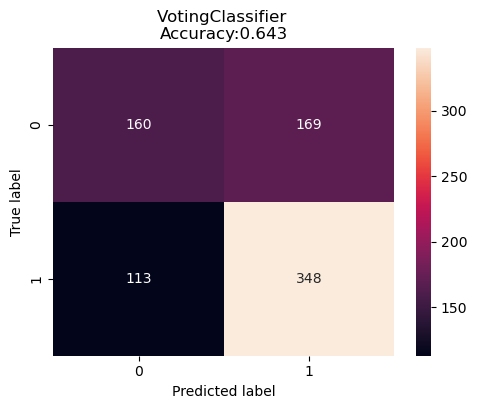

In [36]:
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt="g")
plt.title('VotingClassifier \nAccuracy:{0:.3f}'.format(model.score(X_test, y_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

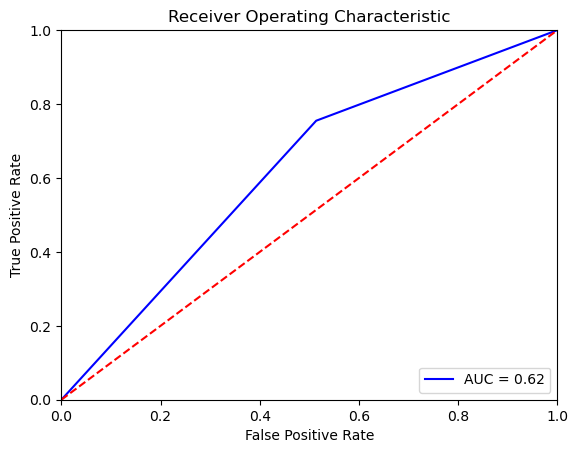

In [37]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# method I: plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
# ROC AUC Score higher is better while Brier Score the lower the better
print("Metrics" + "\t\t" + "My Model" + "\t" + "Elo Results")
print("ROC AUC Score: " +  "\t" + "{:.4f}".format(roc_auc_score(y_test, predicted)) + "\t\t" + "{:.4f}".format(roc_auc_score(test.result, test.elo_prob1)))
print("Brier Score: " + "\t" + "{:.4f}".format(brier_score_loss(y_test, predicted)) + "\t\t" + "{:.4f}".format(brier_score_loss(test.result, test.elo_prob1)))

Metrics		My Model	Elo Results
ROC AUC Score: 	0.6771		0.6818
Brier Score: 	0.2212		0.2189


In [56]:
######Second edits#######
####Implement Sharp and Kelly betting strategies####
import numpy as np

# Calculate returns based on the model's predictions
returns = (predicted - 0.5) * 2  # Scale the predicted probabilities to [-1, 1]

# Calculate the daily returns
daily_returns = returns * y_test

# Calculate the daily log returns
daily_log_returns = np.log(1 + daily_returns)

# Calculate the Sharpe Ratio
sharpe_ratio = np.mean(daily_log_returns) / np.std(daily_log_returns)

# Calculate the Kelly Criterion
winning_prob = np.mean(predictions)  # Estimated probability of winning
print("Winning prob", winning_prob)

odds = 1 / winning_prob - 1  # Convert probability to odds
print("Odds", odds)

kelly_fraction = ((winning_prob * (odds-1)) - (1-winning_prob)) / (odds-1)

# Print the results
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
print("Kelly Criterion Fraction: {:.10f}".format(kelly_fraction))

# Calculate and print the Kelly Criterion bet size
bankroll = 1000  # Your initial bankroll
kelly_bet_size = bankroll * kelly_fraction
print("Kelly Criterion Bet Size: {:.2f}".format(kelly_bet_size))


# Learned Sharpe is working for our model and kelly criterion are expecting to turn us a profit.
# Kelly suggests an extremely risky bet which could be bad depending on your risk tolerance.
# In practice many people bet a fraction of this 


Winning prob 0.6544303797468355
Odds 0.5280464216634428
Sharpe Ratio: 0.35
Kelly Criterion Fraction: 1.3866414194
Kelly Criterion Bet Size: 1386.64
790


In [69]:
####Third edits testing our model on this weeks games#####
#####Dont know current results will have to come back next week to verify####
week10 = pd.read_csv("new.csv")

# predict probabilities
week10_probabilities = model.predict_proba(week10)[:,1]

# predict home team win or lose (0/1)
week10_winner = model.predict(week10)

print(week10_probabilities)
print(week10_winner)




[0.57433823 0.4339573  0.42873306 0.33911438 0.4576637  0.65222739
 0.58573878 0.55528879 0.43395838 0.34188132 0.93937298 0.6676942
 0.53178076 0.70836752]
[1 0 0 0 0 1 1 1 0 0 1 1 1 1]


In [78]:
########Fourth edits use strategies to bet#####
#Compute odds
odds = []
for ele in week10_probabilities:
    odds.append(1/ele - 1)

# Calculate the daily returns based on the model's predictions
returns = (week10_probabilities - 0.5) * 2  # Scale the predicted probabilities to [-1, 1]

# Calculate the daily log returns
daily_log_returns = np.log(1 + returns)

# Calculate the Sharpe Ratio based on your historical data
historical_sharpe_ratio = np.mean(daily_log_returns) / np.std(daily_log_returns)

# Define your risk-free rate
risk_free_rate = 0.02

# Calculate the Kelly Fraction
kelly_fractions = [(p * (b - 1) - (1 - p)) / (b - 1) for p, b in zip(week10_probabilities, odds)]

# Adjust the Kelly Fractions to a reasonable range (e.g., 0 to 1)
kelly_fractions = [max(0, min(1, kf)) for kf in kelly_fractions]

# Your current bankroll
bankroll = 1000  # hypothetical

# Calculate the bet sizes based on the Kelly Fractions and your bankroll
bet_sizes = [risk_free_rate * kf * bankroll for kf in kelly_fractions]

# place bets based on the calculated bet sizes and your predictions
for i, prediction in enumerate(week10_winner):
    if prediction == 1:
        print(f"Place a bet of ${bet_sizes[i]:.2f} on game {i + 1} (Home team win) with odds {odds[i]:.2f}")
    else:
        print(f"No bet on game {i + 1} (Away team win)")



Place a bet of $71.43 on game 1 (Home team win) with odds 0.74
No bet on game 2 (Away team win)
No bet on game 3 (Away team win)
No bet on game 4 (Away team win)
No bet on game 5 (Away team win)
Place a bet of $71.43 on game 6 (Home team win) with odds 0.53
Place a bet of $71.43 on game 7 (Home team win) with odds 0.71
Place a bet of $71.43 on game 8 (Home team win) with odds 0.80
No bet on game 9 (Away team win)
No bet on game 10 (Away team win)
Place a bet of $71.43 on game 11 (Home team win) with odds 0.06
Place a bet of $71.43 on game 12 (Home team win) with odds 0.50
Place a bet of $71.43 on game 13 (Home team win) with odds 0.88
Place a bet of $71.43 on game 14 (Home team win) with odds 0.41
Historical Sharpe Ratio: 0.18
